# Models

In [23]:
# %matplotlib inline
# %load_ext autotime

In [24]:
import sys
import os as os
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle as pkl

import scipy as scipy
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.io.matlab import mat_struct
import pickle
import random

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=True, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## Load session data

In [25]:
Session = 10
mouse = '3C290'

# vis_mice = np.array(['nan', 'beta', 'alpha'])
vis_mice = np.array(['nan', 'alpha', 'beta'])

active_blocks = [1,2,3,5,6]
# active_blocks = [1,2,4,5]

In [ ]:
a_idx = np.where(vis_mice=='alpha')[0][0]
b_idx = np.where(vis_mice=='beta')[0][0]

if len(active_blocks)>4:
    aa_idx=a_idx+4
    bb_idx=b_idx+4
    bl_idx=3
else:
    aa_idx=a_idx+3
    bb_idx=b_idx+3

In [ ]:
# create folder to save results
os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\models')

### Ephys data

In [28]:
KSdir = f"D:\\{mouse}_S{Session}\\Kilosort_2024-05-06_144155\\"

spiketimesfile = KSdir+"spike_times.npy"  
spiketimes = np.load(spiketimesfile)  #### all spiketimes as indexes regardless of cluster

clusterfile = KSdir+"spike_clusters.npy"
spikeclusters = np.load(clusterfile) #### cluster id for each detected spike

Clusterinfofile = KSdir+"cluster_info.tsv"
Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t') #### cluster meta-data matrix

In [29]:
goodclusts = Clusterinfo['cluster_id'][np.where(Clusterinfo['group']=='good')[0]]
goods = []
for clust in goodclusts :
    goods.append(clust)
print(f'Session {Session}: {len(goods)} good clusters')

Session 38: 38 good clusters


In [30]:
goodspiketimes = {}

spikethresh = 1000 # min nb of spikes
for goodunit in goods :
    goodinds = np.where(spikeclusters==goodunit)[0]
    if goodinds.shape[0] > spikethresh : 
        goodspiketimes[goodunit] = spiketimes[goodinds]

### Behavior data

In [31]:
matfile = f"D:\\{mouse}_S{Session}\\Behaviour.mat"
EvaBehavior = loadmat(matfile)

In [32]:
def load_behavioral_event(event_idx, time_to_idx = True):
    '''
    returns dictionary; keys - blocks; inside - array with event :
    time stamps in [sec] if time_to_idx = False
    indexes if time_to_idx = True
    '''
    event_dic = {}

    for block in np.arange(EvaBehavior['Behaviour'].shape[0]) :
        if time_to_idx:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]*20000
        else:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]
        event_dic[block] = event_dic[block].astype(int)
    
    return event_dic

In [33]:
TestSocialSampleWindowPerTrial = load_behavioral_event(12) # 250 ms nosepokes onset|offset
VisitingSocialSamplingTriggers = load_behavioral_event(6) # all vis mouse npokes onset|offset
TestSocialSamplingTriggers = load_behavioral_event(7) # all test mouse npokes onset|offset (not only 250 ms)

TestSocialSampleOnsetPerTrial = load_behavioral_event(10)
TestSocialSampleOffsetPerTrial = load_behavioral_event(11)

## Data prep - firing rate matrix during npoke event

In [ ]:
## find spikes in interesting behavioral window
samplplimg_rate = 20*1000 #20 kHz
beforesamples = 1*samplplimg_rate # 1 sec (expressed in samples for a 20khz sampling rate)
aftersamples = 1*samplplimg_rate # 1 sec
eventlength = 0.25*samplplimg_rate # 0.25 s

# for psth
binsize = 0.05*samplplimg_rate ### 50 ms 
bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

: 

In [ ]:
def find_spikes_in_interesting_behavioral_window(beforesamples, aftersamples, blocks, units=goodspiketimes.keys()):
    ''' 
    beforesamples, aftersamples relative to nosepoke window TestSocialSampleWindowPerTrial; expressed in samples: 0.250 ms = 5000 (20kHz sampling rate)
    blocks=[1,2,4,5]
    '''
    spikes_dic = {}
   
    for block in blocks:
        unitspikes = {}

        for unit in units: # list of good cluster_id
            unitspikes[unit] = {}
            
            for event in np.arange(TestSocialSampleWindowPerTrial[block].shape[0]) : #iterate by npoke events

                onset = TestSocialSampleWindowPerTrial[block][event,0]
                offset = TestSocialSampleWindowPerTrial[block][event,1]
                
                cond1 = np.where(goodspiketimes[unit].astype(int)>=onset-beforesamples)[0]
                cond2 = np.where(goodspiketimes[unit].astype(int)<=offset+aftersamples)[0]
                unitspikes[unit][event] = goodspiketimes[unit][np.intersect1d(cond1,cond2)].astype(int)-onset
                
        spikes_dic[block] = unitspikes
    
    return spikes_dic
        

### Firing rates

firing rate [Hz] = spike_count/ time_window(sec)

* lets find it for each trial for each cell
* we will make an array where each row is trial; each column - neuron; we will collect it in dict where keys = blocks

In [36]:
# 250 ms during the nosepoke
spikes_dic_during = find_spikes_in_interesting_behavioral_window(beforesamples=0, aftersamples=0, blocks=active_blocks)

In [37]:
window = 0.25 #sec
firing_rates_dic = {}

for block in active_blocks:
    firing_rates_2d = []
    for unit in spikes_dic_during[block].keys():
        firing_rates_list = []
        for event in spikes_dic_during[block][unit].keys():
            firing_rate = len(spikes_dic_during[block][unit][event])/window
            firing_rates_list.append(firing_rate)
        firing_rates_vector = np.array(firing_rates_list)
        firing_rates_2d.append(firing_rates_vector)
    firing_rates_matrix = np.array(firing_rates_2d).T
    firing_rates_dic[block] = firing_rates_matrix

In [38]:
firing_rates_dic[2].shape # raws - trials; col - neurons

(30, 30)

### Firing rates filtered

## PCA

In [39]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        #ax.add_patch(Ellipse(position, nsig * width, nsig * height, **kwargs))
        ax.add_patch(Ellipse(position, nsig*width, nsig*height, angle=angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

def plot_gmm_ellipse(gmm, X, label=True, ax=None):
    # ax = ax or plt.gca()
    # labels = gmm.fit(X).predict(X)
    # if label:
    #     ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    # else:
    #     ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    # ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [40]:
firing_rates_concat = np.concatenate([firing_rates_dic[1], firing_rates_dic[2]],axis=0)
pca = PCA(n_components=2)  # You can choose the number of components you want
X_pca = pca.fit_transform(firing_rates_concat)

In [41]:
X_pca.shape

(60, 2)

In [42]:
gmm = GaussianMixture(n_components=2)  # You can choose the number of clusters
gmm.fit(X_pca)

c:\Users\ebukina\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


GaussianMixture(n_components=2)

In [43]:
k = int(X_pca.shape[0]/2)

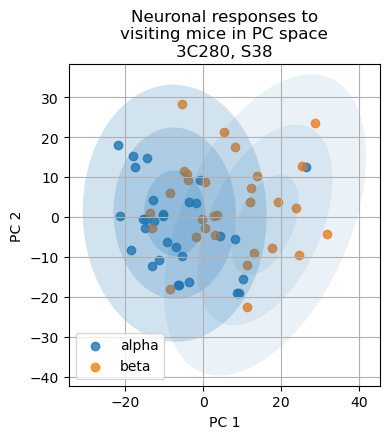

In [44]:
plt.figure(figsize=(4, 4.5))
plt.scatter(X_pca[:k, 0], X_pca[:k, 1], alpha=0.8, label='alpha')
plt.scatter(X_pca[k:, 0], X_pca[k:, 1], alpha=0.8, label='beta')
plot_gmm_ellipse(gmm, X_pca)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title(f'Neuronal responses to\nvisiting mice in PC space\n{mouse}, S{Session}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_pca.png')
plt.show()

## Classifiers

In [82]:
keys = ['evening_cv', 'day_cv', 'morning_cv']
classifiers_results = {key: None for key in keys}

In [83]:
motor_planning_control = False

if motor_planning_control == True:
    choice_1 = EvaBehavior['Behaviour'][1][19]
    choice_2 = EvaBehavior['Behaviour'][2][19]
    choice_3 = EvaBehavior['Behaviour'][4][19]
    choice_4 = EvaBehavior['Behaviour'][5][19]

### Train blocks12; test blocks 34

#### SVM

In [84]:
# Importing necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [85]:
if active_blocks == [1,2,4,5]:
    X_train = np.concatenate((firing_rates_dic[1],firing_rates_dic[2]), axis=0)
    X_test = np.concatenate((firing_rates_dic[4],firing_rates_dic[5]), axis=0)
else:
    X_train = np.concatenate((firing_rates_dic[1],firing_rates_dic[2]), axis=0)
    X_test = np.concatenate((firing_rates_dic[5],firing_rates_dic[6]), axis=0)


if motor_planning_control:
    y_train = np.concatenate((choice_1,choice_2))
    y_test = np.concatenate((choice_3,choice_4))
else:
    y_train = np.concatenate((np.ones(firing_rates_dic[1].shape[0]),np.zeros(firing_rates_dic[1].shape[0])))
    y_test = np.concatenate((np.ones(firing_rates_dic[5].shape[0]),np.zeros(firing_rates_dic[5].shape[0])))

# randomize train
num_rows = X_train.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [86]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((40, 27), (40,), (40, 27), (40,))

In [87]:
from scipy.stats import percentileofscore

In [88]:
SVMs = {}

for kernel in ['linear', 'poly', 'rbf']:

    # collect outcomes
    svm_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
    SVM_results = {key: None for key in svm_keys}

    # real model
    svm_classifier = SVC(kernel=kernel)
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred)
    SVM_results['accuracy'] = accuracy_svm

    # shuffle test
    accuracy_test_shuffle = []
    for shuffle in range(1000):
        # shuffle trials in the matrix
        num_rows = X_test.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        Xctrl = X_test[shuffled_indices]
        accuracy_test_shuffle.append(accuracy_score(y_test, svm_classifier.predict(Xctrl)))
    SVM_results['accuracy_test_shuffle'] = accuracy_test_shuffle

    ## shuffle test stats
    accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
    percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, accuracy_svm)
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_test_shuffle'] = p_value

    # shuffle all
    accuracy_all_shuffle = []
    for shuffle in range(1000):
        ## shuffle train
        num_rows = X_train.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        Xctrl_train = X_train[shuffled_indices]
        random.shuffle(shuffled_indices)
        yctrl_train = y_train[shuffled_indices]

        ## shuffle test
        num_rows = X_test.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        Xctrl = X_test[shuffled_indices]
        random.shuffle(shuffled_indices)
        yctrl = y_test[shuffled_indices]

        svm_classifier_ctrl_all = SVC(kernel=kernel)
        svm_classifier_ctrl_all.fit(Xctrl_train, yctrl_train)
        accuracy_all_shuffle.append(accuracy_score(yctrl, svm_classifier_ctrl_all.predict(Xctrl)))
    SVM_results['accuracy_all_shuffle'] = accuracy_all_shuffle

    ## shuffle all stats
    accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
    percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, accuracy_svm)
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_all_shuffle'] = p_value

    # shuffle train
    accuracy_train_shuffle = []

    for shuffle in range(1000):
        ## shuffle train
        num_rows = X_train.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        Xctrl_train = X_train[shuffled_indices]
        random.shuffle(shuffled_indices)
        yctrl_train = y_train[shuffled_indices]

        svm_classifier_ctrl_train = SVC(kernel=kernel)
        svm_classifier_ctrl_train.fit(Xctrl_train, yctrl_train)
        accuracy_train_shuffle.append(accuracy_score(y_test, svm_classifier_ctrl_train.predict(X_test)))
    SVM_results['accuracy_train_shuffle'] = accuracy_train_shuffle

    ## shuffle all stats
    accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
    percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, accuracy_svm)
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_train_shuffle'] = p_value

    SVMs[kernel] = SVM_results


classifiers_results['evening_cv'] = SVMs


In [89]:
SVMs[kernel]['accuracy']

0.5

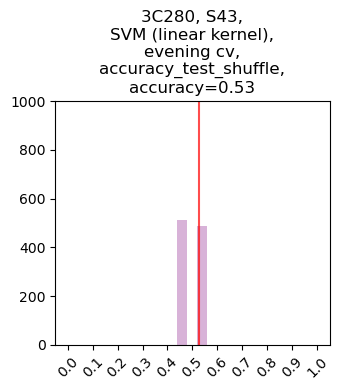

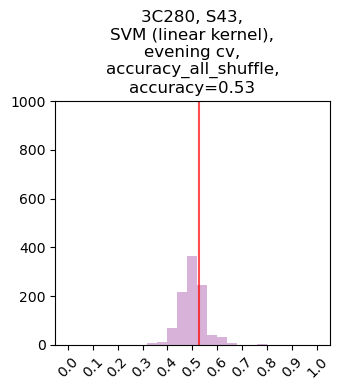

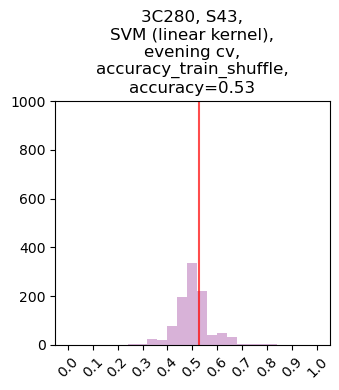

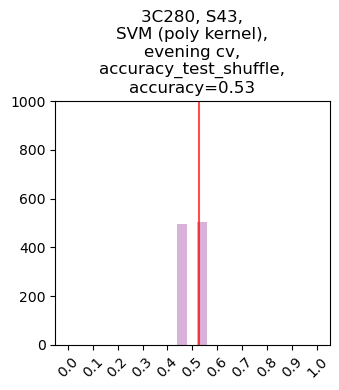

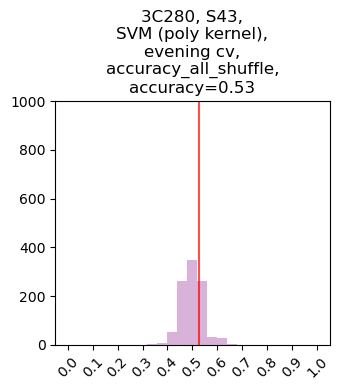

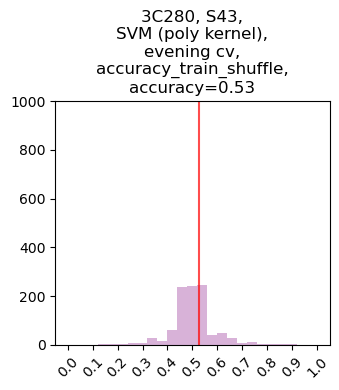

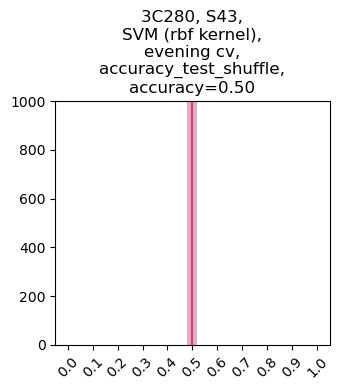

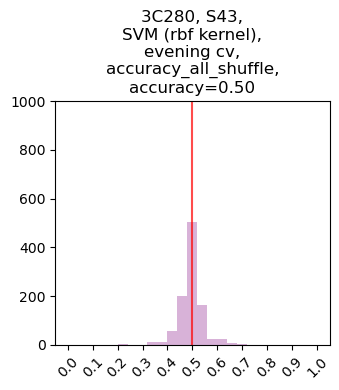

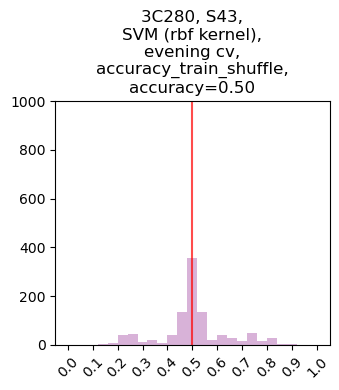

In [90]:
# Plot data
for kernel in ['linear', 'poly', 'rbf']:
    for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
        plt.figure(figsize=(3.5,4)) 
        bin_edges = np.arange(0, 1+0.04, 0.04)
        plt.hist(SVMs[kernel][shuffle], bins=bin_edges, alpha=0.3, color='purple')
        plt.axvline(SVMs[kernel]['accuracy'],color='red', alpha=0.7)
        a = SVMs[kernel]['accuracy']
        plt.title(f'{mouse}, S{Session},\nSVM ({kernel} kernel),\nevening cv,\n{shuffle},\naccuracy={a:.2f}')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, 1.1, 0.1)) 
        plt.ylim(0,1000)
        plt.tight_layout()
        plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_SVM{kernel}_eveningcv_{shuffle}.png', dpi=300, bbox_inches='tight')
        plt.show()

##### Bayes

In [91]:
from sklearn.naive_bayes import GaussianNB

In [92]:
bayes = {}

bayes_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
bayes_results = {key: None for key in svm_keys}

# real model
bayes_classifier = GaussianNB()
bayes_classifier.fit(X_train, y_train)
y_pred = bayes_classifier.predict(X_test)
accuracy_bayes = accuracy_score(y_test, y_pred)
bayes_results['accuracy'] = accuracy_bayes

# shuffle test
accuracy_test_shuffle = []
for shuffle in range(1000):
    # shuffle trials in the matrix
    num_rows = X_test.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl = X_test[shuffled_indices]
    accuracy_test_shuffle.append(accuracy_score(y_test, bayes_classifier.predict(Xctrl)))
bayes_results['accuracy_test_shuffle'] = accuracy_test_shuffle

## shuffle test stats
accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, accuracy_bayes)
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_test_shuffle'] = p_value

# shuffle all
accuracy_all_shuffle = []
for shuffle in range(1000):
    ## shuffle train
    num_rows = X_train.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl_train = X_train[shuffled_indices]
    random.shuffle(shuffled_indices)
    yctrl_train = y_train[shuffled_indices]

    ## shuffle test
    num_rows = X_test.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl = X_test[shuffled_indices]
    random.shuffle(shuffled_indices)
    yctrl = y_test[shuffled_indices]

    bayes_classifier_ctrl_all = GaussianNB()
    bayes_classifier_ctrl_all.fit(Xctrl_train, yctrl_train)
    accuracy_all_shuffle.append(accuracy_score(yctrl, bayes_classifier_ctrl_all.predict(Xctrl)))
bayes_results['accuracy_all_shuffle'] = accuracy_all_shuffle

## shuffle all stats
accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, accuracy_bayes)
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_all_shuffle'] = p_value

# shuffle train
accuracy_train_shuffle = []

for shuffle in range(1000):
    ## shuffle train
    num_rows = X_train.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl_train = X_train[shuffled_indices]
    random.shuffle(shuffled_indices)
    yctrl_train = y_train[shuffled_indices]

    bayes_classifier_ctrl_train = GaussianNB()
    bayes_classifier_ctrl_train.fit(Xctrl_train, yctrl_train)
    accuracy_train_shuffle.append(accuracy_score(y_test, bayes_classifier_ctrl_train.predict(X_test)))
bayes_results['accuracy_train_shuffle'] = accuracy_train_shuffle

## shuffle all stats
accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, accuracy_bayes)
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_train_shuffle'] = p_value

classifiers_results['evening_cv']['bayes'] = bayes_results

In [93]:
classifiers_results['evening_cv'].keys()

dict_keys(['linear', 'poly', 'rbf', 'bayes'])

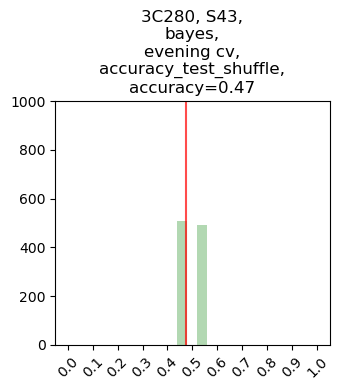

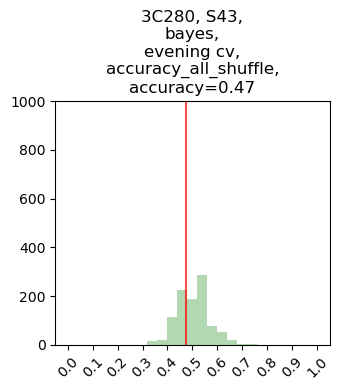

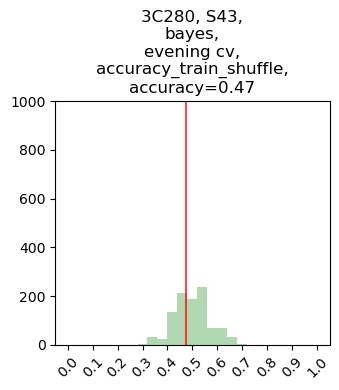

In [94]:
#plot data
for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
    plt.figure(figsize=(3.5,4)) 
    bin_edges = np.arange(0, 1+0.04, 0.04)
    plt.hist(bayes_results[shuffle], bins=bin_edges, alpha=0.3, color='green')
    plt.axvline(bayes_results['accuracy'],color='red', alpha=0.7)
    a =bayes_results['accuracy']
    plt.title(f'{mouse}, S{Session},\nbayes,\nevening cv,\n{shuffle},\naccuracy={a:.2f}')
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.ylim(0,1000)
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_bayes_eveningcv_{shuffle}.png', dpi=300, bbox_inches='tight')
    plt.show()

### Cross-validation on all dataset

#### SVM

In [95]:
# data prep
if active_blocks == [1,2,4,5]:
    alpha_data = np.concatenate((firing_rates_dic[1],firing_rates_dic[4]), axis=0)
    beta_data = np.concatenate((firing_rates_dic[2],firing_rates_dic[5]), axis=0)
else:
    alpha_data = np.concatenate((firing_rates_dic[1],firing_rates_dic[5]), axis=0)
    beta_data = np.concatenate((firing_rates_dic[2],firing_rates_dic[6]), axis=0)

if motor_planning_control:
    y_13 = np.concatenate((choice_1, choice_3))
    y_24 = np.concatenate((choice_2, choice_4))

# randomize morning/evening
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
# y_13 = y_13[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]
# y_24 = y_24[shuffled_indices]

In [96]:
alpha_data.shape, beta_data.shape

((40, 27), (40, 27))

In [97]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

SVMs = {}

for kernel in ['linear', 'poly', 'rbf']:

    # collect outcomes
    svm_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
    SVM_results = {key: None for key in svm_keys}

    accuracy_cv5 = []
    accuracy_test_shuffle = []
    accuracy_all_shuffle = []
    accuracy_train_shuffle = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        svm_classifier_cv = SVC(kernel=kernel)
        svm_classifier_cv.fit(train_ab, y_train)
        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred))

        # shuffle test
        for shuffle in range(1000):
            num_rows = test_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            test_ab_ctrl = test_ab[shuffled_indices]

            y_pred = svm_classifier_cv.predict(test_ab_ctrl)
            accuracy_test_shuffle.append(accuracy_score(y_test, y_pred))

        # all shuffle
        for shuffle in range(1000):
            # shuffle train
            num_rows = train_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            train_ab_ctrl = train_ab[shuffled_indices]

            # shuffle outcomes
            num_rows = test_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            test_ab_ctrl = test_ab[shuffled_indices]

            svm_classifier_cv = SVC(kernel=kernel)
            svm_classifier_cv.fit(train_ab_ctrl, y_train)
            y_pred = svm_classifier_cv.predict(test_ab_ctrl)
            accuracy_all_shuffle.append(accuracy_score(y_test, y_pred))

        # train shuffle
        for shuffle in range(1000):
            # shuffle train
            num_rows = train_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            train_ab_ctrl = train_ab[shuffled_indices]

            svm_classifier_cv = SVC(kernel=kernel)
            svm_classifier_cv.fit(train_ab_ctrl, y_train)
            y_pred = svm_classifier_cv.predict(test_ab)
            accuracy_train_shuffle.append(accuracy_score(y_test, y_pred))
    # save results
    SVM_results['accuracy'] = np.mean(accuracy_cv5)
    SVM_results['accuracy_test_shuffle'] = accuracy_test_shuffle
    SVM_results['accuracy_all_shuffle'] = accuracy_all_shuffle
    SVM_results['accuracy_train_shuffle'] = accuracy_train_shuffle


    ## shuffle test stats
    accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
    percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_test_shuffle'] = p_value   

    ## shuffle test stats
    accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
    percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_all_shuffle'] = p_value

    ## shuffle test stats
    accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
    percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_train_shuffle'] = p_value

    SVMs[kernel] = SVM_results

classifiers_results['day_cv'] = SVMs

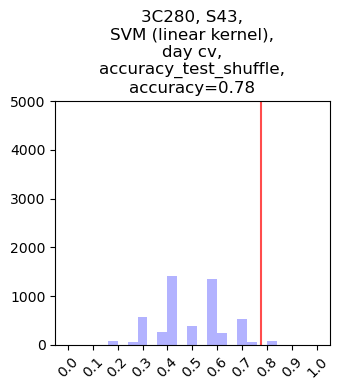

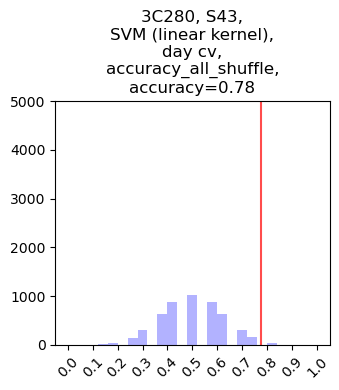

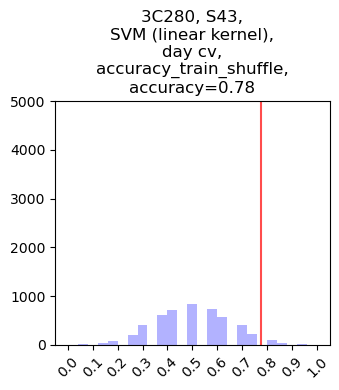

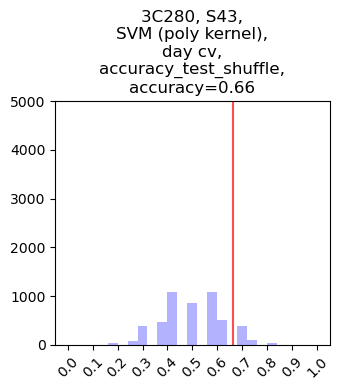

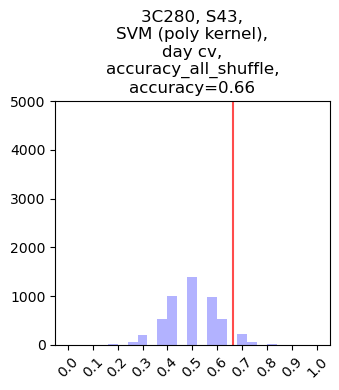

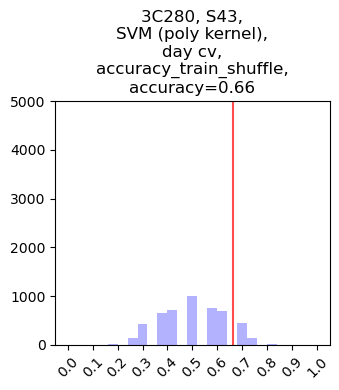

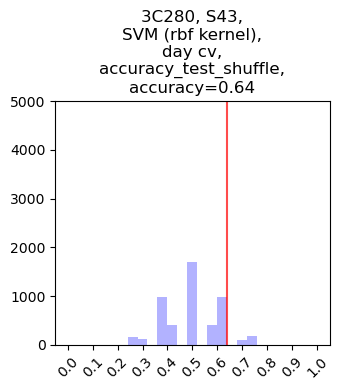

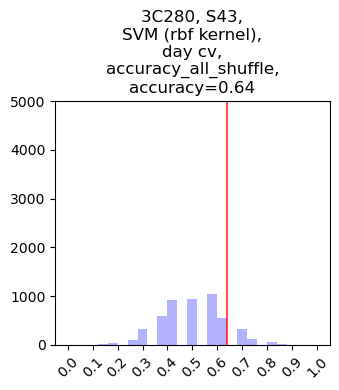

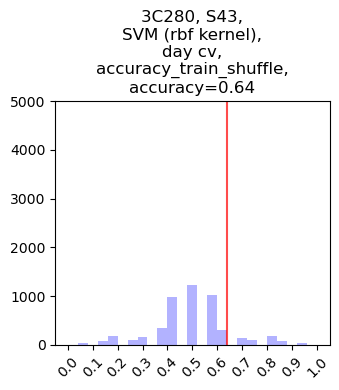

In [98]:
# Plot data
for kernel in ['linear', 'poly', 'rbf']:
    for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
        plt.figure(figsize=(3.5,4)) 
        bin_edges = np.arange(0, 1+0.04, 0.04)
        plt.hist(SVMs[kernel][shuffle], bins=bin_edges, alpha=0.3, color='blue')
        plt.axvline(SVMs[kernel]['accuracy'],color='red', alpha=0.7)
        a=SVMs[kernel]['accuracy']
        plt.title(f'{mouse}, S{Session},\nSVM ({kernel} kernel),\nday cv,\n{shuffle},\naccuracy={a:.2f}')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, 1.1, 0.1)) 
        plt.ylim(0,5000)
        plt.tight_layout()
        plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_SVM{kernel}_daycv_{shuffle}.png', dpi=300, bbox_inches='tight')
        plt.show()

#### Bayes

In [99]:
# data prep
if active_blocks == [1,2,4,5]:
    alpha_data = np.concatenate((firing_rates_dic[1],firing_rates_dic[4]), axis=0)
    beta_data = np.concatenate((firing_rates_dic[2],firing_rates_dic[5]), axis=0)
else:
    alpha_data = np.concatenate((firing_rates_dic[1],firing_rates_dic[5]), axis=0)
    beta_data = np.concatenate((firing_rates_dic[2],firing_rates_dic[6]), axis=0)

if motor_planning_control:
    y_13 = np.concatenate((choice_1, choice_3))
    y_24 = np.concatenate((choice_2, choice_4))

# randomize morning/evening
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
# y_13 = y_13[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]
# y_24 = y_24[shuffled_indices]

In [100]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

bayes = {}

bayes_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
bayes_results = {key: None for key in svm_keys}

accuracy_cv5 = []
accuracy_test_shuffle = []
accuracy_all_shuffle = []
accuracy_train_shuffle = []

for n in range(cv):

    # data prep
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    # dataset
    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)
    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

    # randomize train
    num_rows = train_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_ab = train_ab[shuffled_indices]
    y_train = y_train[shuffled_indices]

    # actual prediction
    classifier = GaussianNB()
    classifier.fit(train_ab, y_train)
    y_pred = classifier.predict(test_ab)
    accuracy_cv5.append(accuracy_score(y_test, y_pred))

    # test shuffle
    for shuffle in range(1000):
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab_ctrl = test_ab[shuffled_indices]

        y_pred = classifier.predict(test_ab_ctrl)
        accuracy_test_shuffle.append(accuracy_score(y_test, y_pred))

    # all shuffle
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab_ctrl = train_ab[shuffled_indices]

        # shuffle outcomes
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab_ctrl = test_ab[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab_ctrl, y_train)
        y_pred = classifier.predict(test_ab_ctrl)
        accuracy_all_shuffle.append(accuracy_score(y_test, y_pred))

    # train shuffle
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab_ctrl = train_ab[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab_ctrl, y_train)
        y_pred = classifier.predict(test_ab)
        accuracy_train_shuffle.append(accuracy_score(y_test, y_pred))

# save results
bayes_results['accuracy'] = np.mean(accuracy_cv5)
bayes_results['accuracy_test_shuffle'] = accuracy_test_shuffle
bayes_results['accuracy_all_shuffle'] = accuracy_all_shuffle
bayes_results['accuracy_train_shuffle'] = accuracy_train_shuffle

## shuffle test stats
accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_test_shuffle'] = p_value   

## shuffle test stats
accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_all_shuffle'] = p_value

## shuffle test stats
accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_train_shuffle'] = p_value

classifiers_results['day_cv']['bayes'] = bayes_results

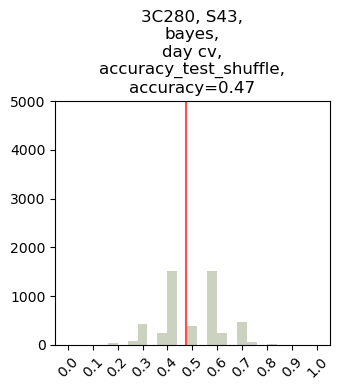

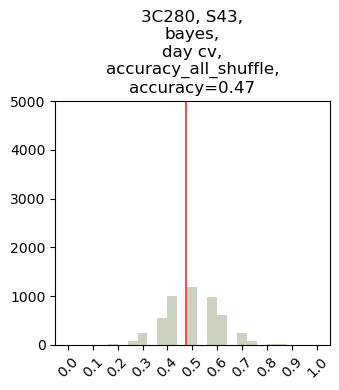

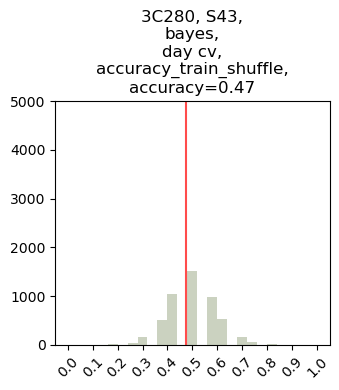

In [101]:
#plot data
for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
    plt.figure(figsize=(3.5,4)) 
    bin_edges = np.arange(0, 1+0.04, 0.04)
    plt.hist(bayes_results[shuffle], bins=bin_edges, alpha=0.3, color='#556B2F')
    plt.axvline(bayes_results['accuracy'],color='red', alpha=0.7)
    a=bayes_results['accuracy']
    plt.title(f'{mouse}, S{Session},\nbayes,\nday cv,\n{shuffle},\naccuracy={a:.2f}')
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.ylim(0,5000)
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_bayes_daycv_{shuffle}.png', dpi=300, bbox_inches='tight')
    plt.show()

### cross val on morning data

In [102]:
# data prep
alpha_data = firing_rates_dic[1]
beta_data = firing_rates_dic[2]

# randomize morning/evening
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]

In [103]:
# alpha_data.shape, beta_data.shape

In [104]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

SVMs = {}

for kernel in ['linear', 'poly', 'rbf']:

    # collect outcomes
    svm_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
    SVM_results = {key: None for key in svm_keys}

    accuracy_cv5 = []
    accuracy_test_shuffle = []
    accuracy_all_shuffle = []
    accuracy_train_shuffle = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        svm_classifier_cv = SVC(kernel=kernel)
        svm_classifier_cv.fit(train_ab, y_train)
        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred))

        # shuffle test
        for shuffle in range(1000):
            num_rows = test_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            test_ab_ctrl = test_ab[shuffled_indices]

            y_pred = svm_classifier_cv.predict(test_ab_ctrl)
            accuracy_test_shuffle.append(accuracy_score(y_test, y_pred))

        # all shuffle
        for shuffle in range(1000):
            # shuffle train
            num_rows = train_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            train_ab_ctrl = train_ab[shuffled_indices]

            # shuffle outcomes
            num_rows = test_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            test_ab_ctrl = test_ab[shuffled_indices]

            svm_classifier_cv = SVC(kernel=kernel)
            svm_classifier_cv.fit(train_ab_ctrl, y_train)
            y_pred = svm_classifier_cv.predict(test_ab_ctrl)
            accuracy_all_shuffle.append(accuracy_score(y_test, y_pred))

        # train shuffle
        for shuffle in range(1000):
            # shuffle train
            num_rows = train_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            train_ab_ctrl = train_ab[shuffled_indices]

            svm_classifier_cv = SVC(kernel=kernel)
            svm_classifier_cv.fit(train_ab_ctrl, y_train)
            y_pred = svm_classifier_cv.predict(test_ab)
            accuracy_train_shuffle.append(accuracy_score(y_test, y_pred))
    # save results
    SVM_results['accuracy'] = np.mean(accuracy_cv5)
    SVM_results['accuracy_test_shuffle'] = accuracy_test_shuffle
    SVM_results['accuracy_all_shuffle'] = accuracy_all_shuffle
    SVM_results['accuracy_train_shuffle'] = accuracy_train_shuffle


    ## shuffle test stats
    accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
    percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_test_shuffle'] = p_value   

    ## shuffle test stats
    accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
    percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_all_shuffle'] = p_value

    ## shuffle test stats
    accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
    percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_train_shuffle'] = p_value

    SVMs[kernel] = SVM_results

classifiers_results['morning_cv'] = SVMs


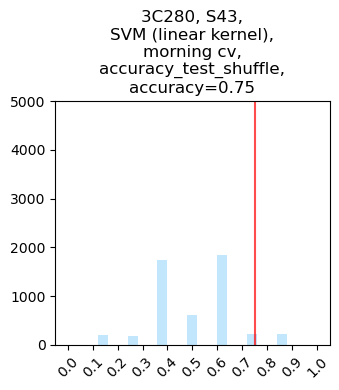

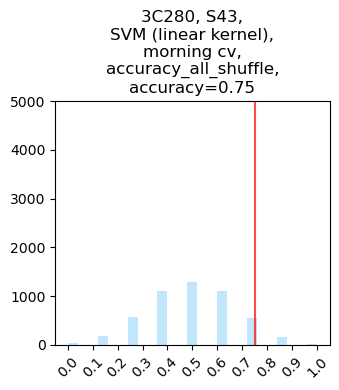

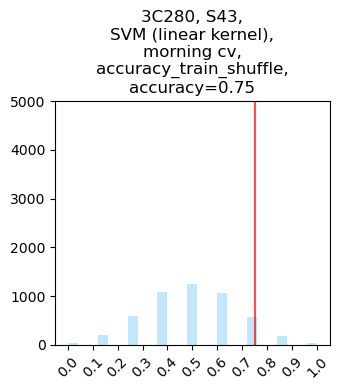

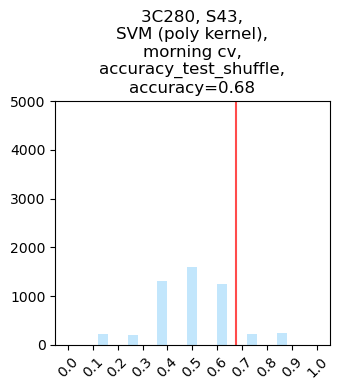

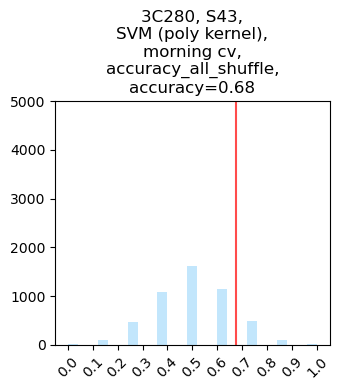

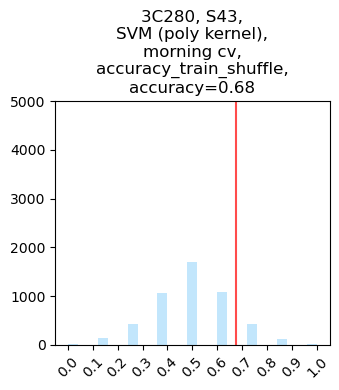

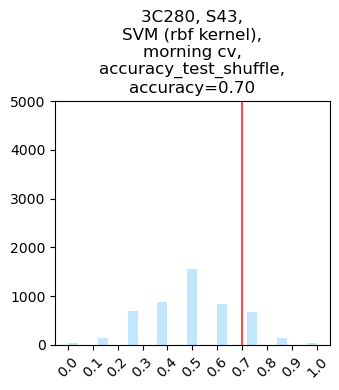

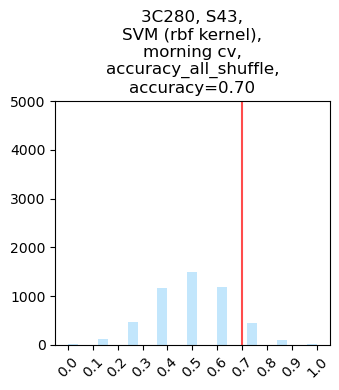

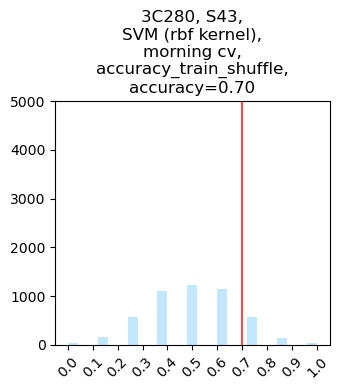

In [105]:
# Plot data
for kernel in ['linear', 'poly', 'rbf']:
    for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
        plt.figure(figsize=(3.5,4)) 
        bin_edges = np.arange(0, 1+0.04, 0.04)
        plt.hist(SVMs[kernel][shuffle], bins=bin_edges, alpha=0.5, color='#87CEFA')
        plt.axvline(SVMs[kernel]['accuracy'],color='red', alpha=0.7)
        a=SVMs[kernel]['accuracy']
        plt.title(f'{mouse}, S{Session},\nSVM ({kernel} kernel),\nmorning cv,\n{shuffle},\naccuracy={a:.2f}')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, 1.1, 0.1)) 
        plt.ylim(0,5000)
        plt.tight_layout()
        plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_SVM{kernel}_morningcv_{shuffle}.png', dpi=300, bbox_inches='tight')
        plt.show()

#### Bayes

In [106]:
# data prep
alpha_data = firing_rates_dic[1]
beta_data = firing_rates_dic[2]

# randomize morning/evening
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]

In [107]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

bayes = {}

bayes_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
bayes_results = {key: None for key in svm_keys}

accuracy_cv5 = []
accuracy_test_shuffle = []
accuracy_all_shuffle = []
accuracy_train_shuffle = []

for n in range(cv):

    # data prep
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    # dataset
    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)
    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

    # randomize train
    num_rows = train_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_ab = train_ab[shuffled_indices]
    y_train = y_train[shuffled_indices]

    # actual prediction
    classifier = GaussianNB()
    classifier.fit(train_ab, y_train)
    y_pred = classifier.predict(test_ab)
    accuracy_cv5.append(accuracy_score(y_test, y_pred))

    # test shuffle
    for shuffle in range(1000):
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab_ctrl = test_ab[shuffled_indices]

        y_pred = classifier.predict(test_ab_ctrl)
        accuracy_test_shuffle.append(accuracy_score(y_test, y_pred))

    # all shuffle
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab_ctrl = train_ab[shuffled_indices]

        # shuffle outcomes
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab_ctrl = test_ab[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab_ctrl, y_train)
        y_pred = classifier.predict(test_ab_ctrl)
        accuracy_all_shuffle.append(accuracy_score(y_test, y_pred))

    # train shuffle
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab_ctrl = train_ab[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab_ctrl, y_train)
        y_pred = classifier.predict(test_ab)
        accuracy_train_shuffle.append(accuracy_score(y_test, y_pred))

# save results
bayes_results['accuracy'] = np.mean(accuracy_cv5)
bayes_results['accuracy_test_shuffle'] = accuracy_test_shuffle
bayes_results['accuracy_all_shuffle'] = accuracy_all_shuffle
bayes_results['accuracy_train_shuffle'] = accuracy_train_shuffle

## shuffle test stats
accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_test_shuffle'] = p_value   

## shuffle test stats
accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_all_shuffle'] = p_value

## shuffle test stats
accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_train_shuffle'] = p_value


classifiers_results['morning_cv']['bayes'] = bayes_results


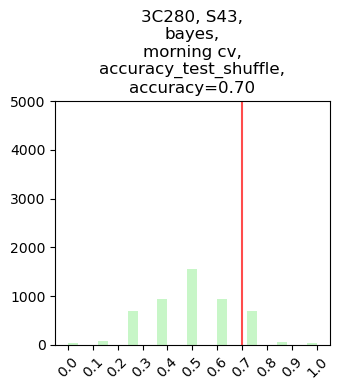

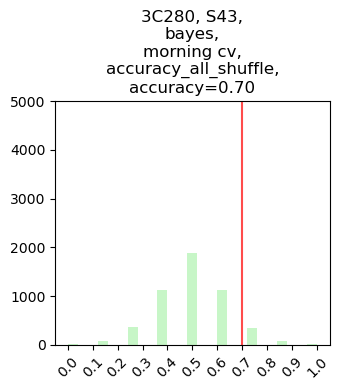

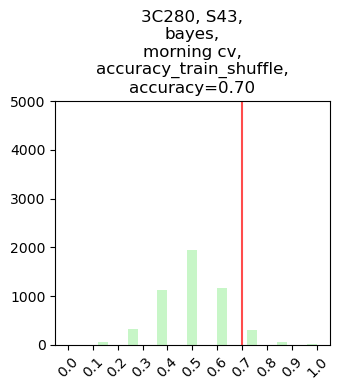

In [108]:
#plot data
for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
    plt.figure(figsize=(3.5,4)) 
    bin_edges = np.arange(0, 1+0.04, 0.04)
    plt.hist(bayes_results[shuffle], bins=bin_edges, alpha=0.5, color='#90EE90')
    plt.axvline(bayes_results['accuracy'],color='red', alpha=0.7)
    a=bayes_results['accuracy']
    plt.title(f'{mouse}, S{Session},\nbayes,\nmorning cv,\n{shuffle},\naccuracy={a:.2f}')
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.ylim(0,5000)
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_bayes_morningcv_{shuffle}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [109]:
classifiers_results

{'evening_cv': {'linear': {'accuracy': 0.525,
   'accuracy_test_shuffle': [0.475,
    0.475,
    0.525,
    0.525,
    0.475,
    0.475,
    0.475,
    0.475,
    0.475,
    0.525,
    0.525,
    0.475,
    0.525,
    0.525,
    0.525,
    0.475,
    0.525,
    0.525,
    0.475,
    0.525,
    0.525,
    0.475,
    0.525,
    0.525,
    0.475,
    0.525,
    0.525,
    0.475,
    0.525,
    0.525,
    0.475,
    0.475,
    0.475,
    0.525,
    0.475,
    0.475,
    0.475,
    0.475,
    0.475,
    0.525,
    0.475,
    0.475,
    0.525,
    0.525,
    0.475,
    0.475,
    0.475,
    0.525,
    0.475,
    0.475,
    0.525,
    0.525,
    0.525,
    0.525,
    0.475,
    0.475,
    0.475,
    0.475,
    0.525,
    0.475,
    0.475,
    0.525,
    0.475,
    0.475,
    0.525,
    0.475,
    0.525,
    0.525,
    0.525,
    0.475,
    0.525,
    0.475,
    0.475,
    0.475,
    0.525,
    0.525,
    0.475,
    0.475,
    0.475,
    0.525,
    0.475,
    0.525,
    0.475,
    0.475,
    0

In [110]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_classifiers_results.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(classifiers_results, f)

In [111]:
# # load
# with open(save_path, 'rb') as f:
#     classifiers_results = pickle.load(f)
# classifiers_results

In [112]:
classifiers_results['morning_cv'].keys()

dict_keys(['linear', 'poly', 'rbf', 'bayes'])

In [113]:
for cv in ['evening_cv','day_cv','morning_cv']:
    print(cv)
    print()
    for model in ['linear', 'poly', 'rbf', 'bayes']:

        print(model)
        print(round(classifiers_results[cv][model]['accuracy'], 3))
        print(round(classifiers_results[cv][model]['pval_all_shuffle'], 3))
        print(round(classifiers_results[cv][model]['pval_train_shuffle'], 3))
        print(round(classifiers_results[cv][model]['pval_test_shuffle'], 3))
        print()
    print('---------------------------------------')
    print()
    

evening_cv

linear
0.525
0.243
0.28
0.243

poly
0.525
0.228
0.31
0.251

rbf
0.5
0.469
0.512
0.499

bayes
0.475
0.698
0.658
0.745

---------------------------------------

day_cv

linear
0.775
0.009
0.03
0.015

poly
0.662
0.057
0.121
0.101

rbf
0.638
0.098
0.11
0.055

bayes
0.475
0.621
0.647
0.539

---------------------------------------

morning_cv

linear
0.75
0.091
0.1
0.065

poly
0.675
0.119
0.113
0.091

rbf
0.7
0.111
0.149
0.172

bayes
0.7
0.084
0.075
0.158

---------------------------------------

